Loading the image dataset

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


TensorFlow version= 2.3.0
X train = 14034, X test = 3000, Y train = 14034, Y test = 3000


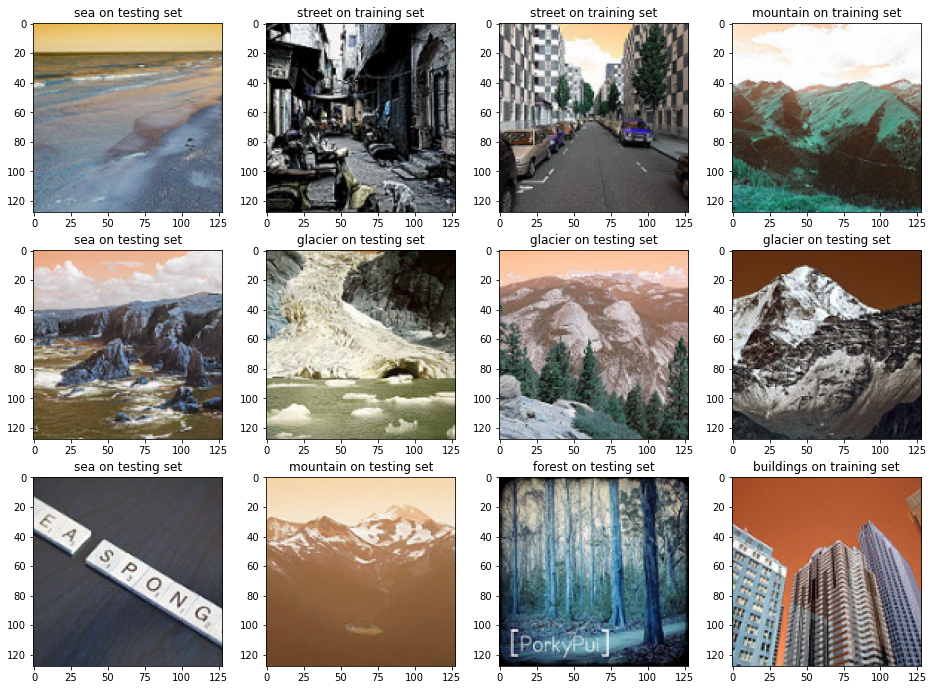

In [1]:
from sklearnex import patch_sklearn
patch_sklearn()
#https://intel.github.io/scikit-learn-intelex/

from operator import ge
import os
import pandas as pd
import cv2
import random
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.metrics import confusion_matrix

import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

print(f'TensorFlow version= {tf.__version__}')

CNAMES = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

def get_imageset(train_or_test):
    train_or_test = train_or_test.lower()
    IMGSIZE = (128, 128)
    X, y = [], []

    _path = 'archive'
    _labels = CNAMES

    for label in _labels:
        path = _path + '/seg_' + train_or_test + '/seg_' + train_or_test +'/' + label
        for f in sorted([_ for _ in os.listdir(path) if _.lower().endswith('.jpg')]):
            X += [cv2.resize(cv2.imread(os.path.join(path,f)), IMGSIZE)]
            y += [CNAMES.index(label)]
    return X, y


X_tr, y_tr = get_imageset('train')
X_ts, y_ts = get_imageset('test')


#sanity check
print(f'X train = {len(X_tr)}, X test = {len(X_ts)}, Y train = {len(y_tr)}, Y test = {len(y_ts)}')

#display images
plt.figure(figsize=(16,16))

def plot_image(_ax, _i, train_or_test):
    if train_or_test == 0:
        _ax.imshow(X_tr[_i])
        _ax.set_title(f'{CNAMES[y_tr[_i]]} on training set')
    else:
        _ax.imshow(X_ts[_i])
        _ax.set_title(f'{CNAMES[y_ts[_i]]} on testing set')


#if train random from 1 to 14034
#else test random from 1 to 3000

for i in range(12):
    tr_or_ts = random.randint(0, 1) #0 gets image from train, 1 gets image from train
    ax=plt.subplot(4, 4, i + 1)
    if tr_or_ts == 0:      
        plot_image(ax, random.randint(1, 14034), tr_or_ts)
    else:
        plot_image(ax, random.randint(1, 3000), tr_or_ts)
        
plt.show()

There are 3 image channels because its an RGB image

Converting the imageset to numpy array, such as the array size:
(14034, 128, 128, 3) and scaling the imageset to [0-1].

In [2]:
from numpy import asarray
from sklearn.preprocessing import minmax_scale

def convert_imageset(imageset):
    _imageset = asarray(imageset)
    shape = _imageset.shape
    imageset_scaled = minmax_scale(_imageset.ravel(), feature_range=(0,1)).reshape(shape)
    return imageset_scaled

X_tr = np.float32(convert_imageset(X_tr))
X_ts = np.float32(convert_imageset(X_ts))
y_tr = np.array(y_tr, dtype='int32')
y_ts = np.array(y_ts, dtype='int32')

print(X_tr.shape)
print(X_ts.shape)

(14034, 128, 128, 3)
(3000, 128, 128, 3)


Convolutional neural network

In [3]:
from tensorflow import keras
from tensorflow.keras import layers

def cnn_model():
    inputs = keras.Input(shape=(128, 128, 3))
    x = layers.Conv2D(32, 3)(inputs)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3)(x)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3)(x)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(10)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

model = cnn_model()

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(lr=3e-4),
    metrics=["accuracy"],
)


model.fit(X_tr, y_tr, batch_size=64, epochs=10, verbose=2)
model.evaluate(X_ts, y_ts, batch_size=64, verbose=2)

Train on 14034 samples
Epoch 1/10
14034/14034 - 155s - loss: 1.2793 - accuracy: 0.6288
Epoch 2/10
14034/14034 - 155s - loss: 0.6163 - accuracy: 0.7862
Epoch 3/10
14034/14034 - 154s - loss: 0.4316 - accuracy: 0.8499
Epoch 4/10
14034/14034 - 148s - loss: 0.3162 - accuracy: 0.8925
Epoch 5/10
14034/14034 - 148s - loss: 0.2230 - accuracy: 0.9245
Epoch 6/10
14034/14034 - 149s - loss: 0.1616 - accuracy: 0.9492
Epoch 7/10
14034/14034 - 149s - loss: 0.1097 - accuracy: 0.9693
Epoch 8/10
14034/14034 - 148s - loss: 0.1124 - accuracy: 0.9667
Epoch 9/10
14034/14034 - 148s - loss: 0.1085 - accuracy: 0.9657
Epoch 10/10
14034/14034 - 149s - loss: 0.0484 - accuracy: 0.9887
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


[0.815489842414856, 0.7876667]

Rregularization and/or drop-out features. 
Reporting performance

In [5]:
from tensorflow.keras import layers, regularizers

def cnn_model_regularized():
    inputs = keras.Input(shape=(128, 128, 3))
    x = layers.Conv2D(32, 3, padding="same", kernel_regularizer=regularizers.l2(0.01),)(
        inputs
    )
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, padding="same", kernel_regularizer=regularizers.l2(0.01),)(
        x
    )
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(
        128, 3, padding="same", kernel_regularizer=regularizers.l2(0.01),
    )(x)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01),)(
        x
    )
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(10)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


model = cnn_model_regularized()
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(lr=3e-4),
    metrics=["accuracy"],
)

model.fit(X_tr, y_tr, batch_size=64, epochs=10, verbose=2)
model.evaluate(X_ts, y_ts, batch_size=64, verbose=2)

Train on 14034 samples
Epoch 1/10
14034/14034 - 172s - loss: 4.0943 - accuracy: 0.3361
Epoch 2/10
14034/14034 - 172s - loss: 2.9277 - accuracy: 0.3658
Epoch 3/10
14034/14034 - 170s - loss: 2.4261 - accuracy: 0.3746
Epoch 4/10
14034/14034 - 171s - loss: 2.1533 - accuracy: 0.3922
Epoch 5/10
14034/14034 - 171s - loss: 1.9548 - accuracy: 0.3745
Epoch 6/10
14034/14034 - 172s - loss: 1.8526 - accuracy: 0.3664
Epoch 7/10
14034/14034 - 171s - loss: 1.7371 - accuracy: 0.4037
Epoch 8/10
14034/14034 - 171s - loss: 1.6482 - accuracy: 0.4217
Epoch 9/10
14034/14034 - 172s - loss: 1.5879 - accuracy: 0.4207
Epoch 10/10
14034/14034 - 170s - loss: 1.5386 - accuracy: 0.4225


[2.816179171085358, 0.24866667]

Based on my results, controlling the model complexity using regularization and minimizing the loss function resulted in worse performance. Hence only using the previous model with only the Keras API from Tensorflow, provided better prediction based on the accuracy value.